# CMIP6 use case

**Description**

Contents:
* [Loading and filtering the data](#Loading-and-filtering-the-data)
* [Postprocessing and combining the data](#Postprocessing-and-combining-the-data)
* [Visualizing multimodel ensemble](#Visualizing-multimodel-ensemble)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import intake
from dask.diagnostics import ProgressBar

## Loading and filtering the data

In [2]:
# Initialize the Pangeo CMIP6 cloud collection
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [3]:
# View available datasets
col.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hfls,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,zg,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
511420,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,sfcWind,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511421,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,uas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511422,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,day,rlut,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511423,ScenarioMIP,AS-RCEC,TaiESM1,ssp585,r1i1p1f1,day,tasmin,gn,gs://cmip6/CMIP6/ScenarioMIP/AS-RCEC/TaiESM1/s...,NaN,20210721


We have a catalog of CMIP datasets that are available on Pangeo, but we would like to filter these results by searching for datasets which match what we want. For instance, we would like to consider models which contain the variables 'tos' and 'no3os' (surface temperature and nitrate concentrations), and we'll also search for models that have both historical and SSP5-8.5 runs.

In [4]:
# function which shows us what different models we have which has specific experiment_id and variable_id
def model_list(experiment_id1, experiment_id2, variable_id1, variable_id2):
    # exp_list_1: all model runs containing experiment "experiment_id1"
    # exp_list_2: all model runs containing experiment "experiment_id2"
    exp_list_1 = col.df[col.df['experiment_id'] == experiment_id1].source_id.unique()
    exp_list_2 = col.df[col.df['experiment_id'] == experiment_id2].source_id.unique()

    # Models which have both experiments experiment_id1 and experiment_id2
    exp_list_intersect = np.intersect1d(exp_list_1, exp_list_2)

    # var_list_1: all model runs containing field "variable_id1"
    # var_list_2: all model runs containing field "variable_id2"
    var_list_1 = col.df[col.df['variable_id'] == variable_id1].source_id.unique()
    var_list_2 = col.df[col.df['variable_id'] == variable_id2].source_id.unique()

    var_list_intersect = np.intersect1d(var_list_1, var_list_2)

    model = np.intersect1d(exp_list_intersect, var_list_intersect)
    return model

model_list('historical','ssp585','tos','no3os')

array(['ACCESS-ESM1-5', 'CESM2', 'CESM2-WACCM', 'CNRM-ESM2-1', 'CanESM5',
       'CanESM5-CanOE', 'GFDL-ESM4', 'GISS-E2-1-G', 'IPSL-CM6A-LR',
       'MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'NorESM2-LM',
       'NorESM2-MM', 'UKESM1-0-LL'], dtype=object)

In [5]:
# Search collection for matching datasets 
models = ['ACCESS-ESM1-5','CESM2','CESM2-WACCM']
variables = ['tos', 'no3os']
experiments = ['historical', 'ssp585']

cat = col.search(
    variable_id=variables,
    experiment_id=experiments,
    source_id=models,
    grid_label='gn',
    table_id='Omon',
    member_id = ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r1i1p2f1', 'r2i1p2f1', 'r3i1p2f1']
)

In [6]:
# Load using cmip6_preprocessing's combined_preprocessing function
from cmip6_preprocessing.preprocessing import combined_preprocessing

ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False,
    preprocess=combined_preprocessing,
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


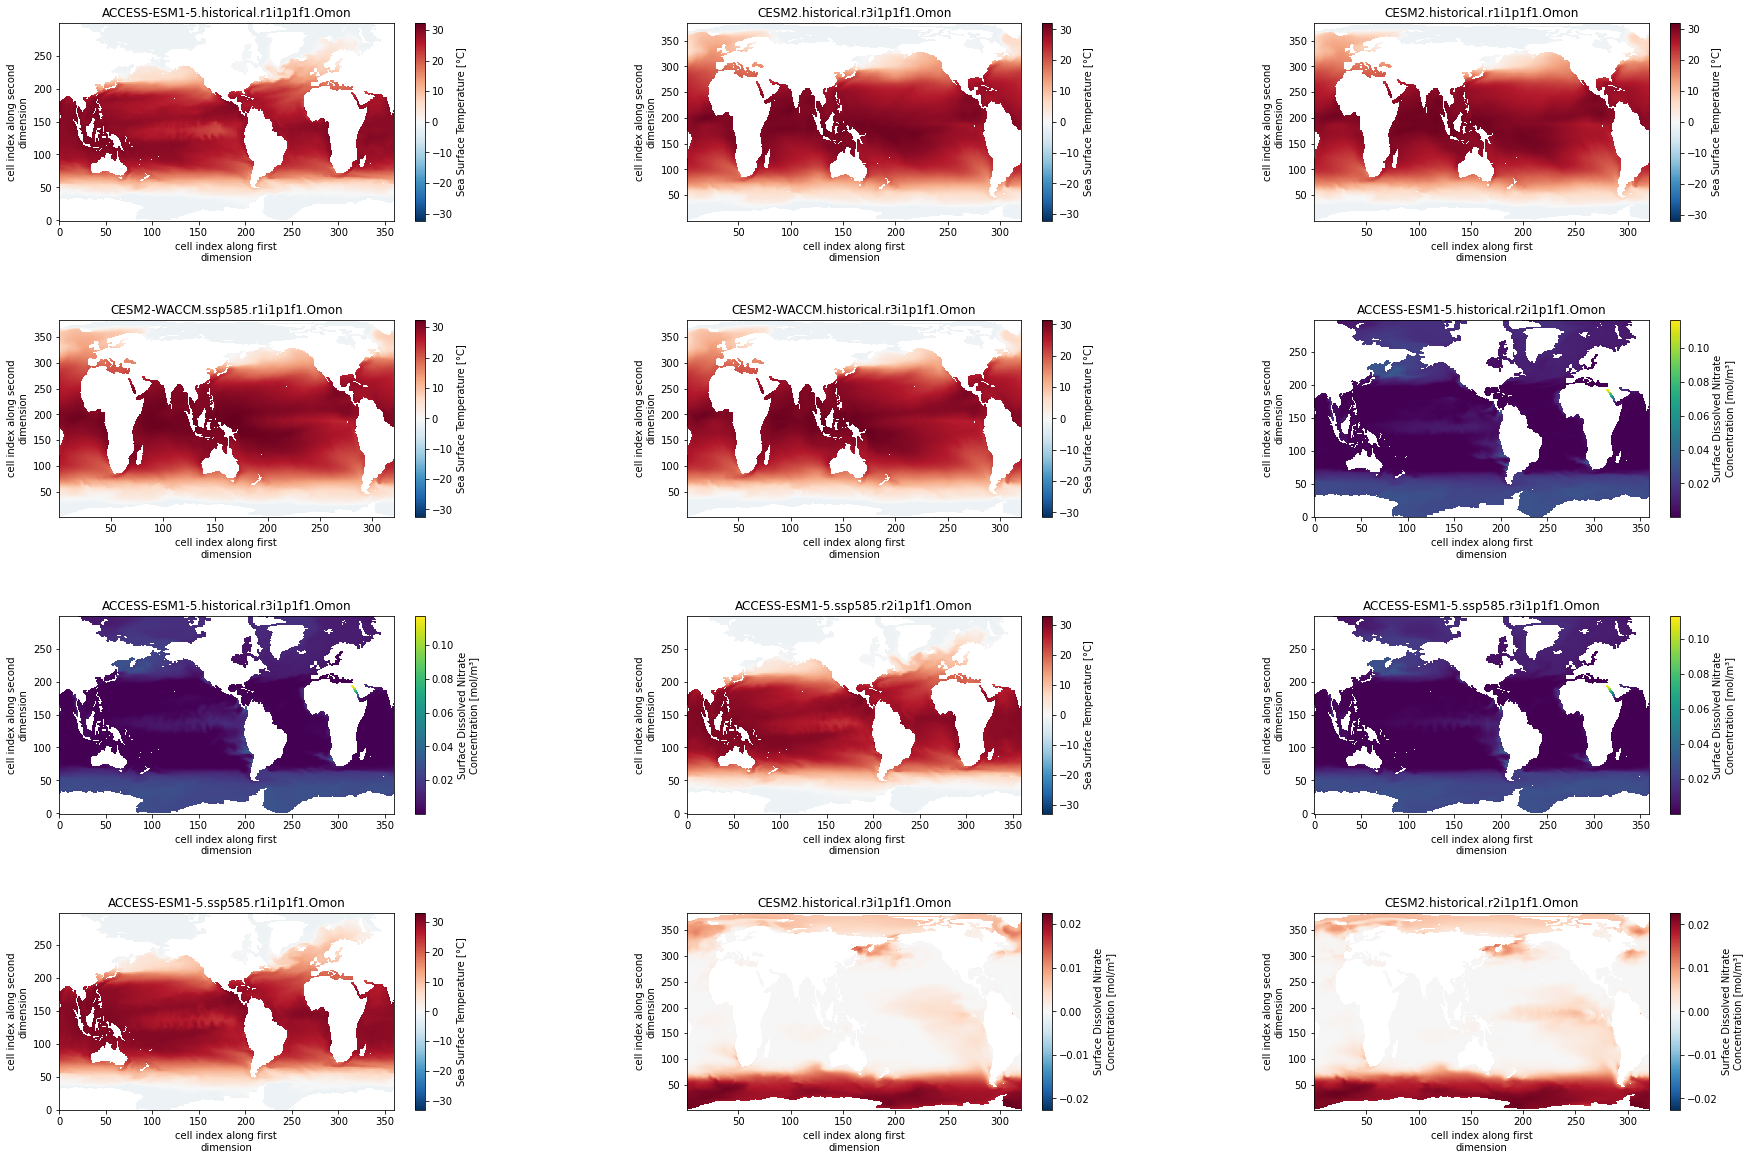

In [7]:
# quick example of how to loop over several models
from cmip6_preprocessing.utils import cmip6_dataset_id
fig, axarr = plt.subplots(ncols=3, nrows=4, figsize=[30,20])
for ax, (name, ds) in zip(axarr.flat, ddict.items()):
    # select the first time step
    ds = ds.isel(time=100)
    # select the datavariable
    da = ds[ds.variable_id]
    # plot
    
    da.plot(ax=ax)
    ax.set_title('.'.join(cmip6_dataset_id(ds).split('.')[2:6]))
    
fig.subplots_adjust(hspace=0.5, wspace=0.5)

## Postprocessing and combining the data

We would like to do the following:
1. Drop any models that do not have _both_ `tos` and `no3os` variables
2. Concatenate historical runs to SSP5-8.5 experiments

In [8]:
from cmip6_preprocessing.postprocessing import merge_variables, concat_members, concat_experiments

In [9]:
# Merge different variables from the same model runs into the same datasets\
ddict_combined = merge_variables(ddict)

# Print list of model runs
ddict_combined.keys()

/srv/conda/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2.historical.r3i1p1f1.Omon.gn.none.tos failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2.historical.r1i1p1f1.Omon.gn.none.tos failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2.historical.r2i1p1f1.Omon.gn.none.no3os failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")


dict_keys(['ACCESS-ESM1-5.gn.historical.Omon.r1i1p1f1', 'CESM2-WACCM.gn.ssp585.Omon.r1i1p1f1', 'CESM2-WACCM.gn.historical.Omon.r3i1p1f1', 'ACCESS-ESM1-5.gn.historical.Omon.r2i1p1f1', 'ACCESS-ESM1-5.gn.historical.Omon.r3i1p1f1', 'ACCESS-ESM1-5.gn.ssp585.Omon.r2i1p1f1', 'ACCESS-ESM1-5.gn.ssp585.Omon.r3i1p1f1', 'ACCESS-ESM1-5.gn.ssp585.Omon.r1i1p1f1', 'CESM2-WACCM.gn.historical.Omon.r1i1p1f1', 'CESM2-WACCM.gn.ssp585.Omon.r2i1p1f1', 'CESM2-WACCM.gn.ssp585.Omon.r3i1p1f1', 'CESM2-WACCM.gn.historical.Omon.r2i1p1f1'])

In [10]:
# Drop any datasets without both 'tos' and 'no3os'
for model_run in list(ddict_combined.keys()):
    if 'tos' not in ddict_combined[model_run] or 'no3os' not in ddict_combined[model_run]:
        ddict_combined.pop(model_run)

# Print new list of model runs, dropping any model runs that don't have both 'tos' and 'no3os'
ddict_combined.keys()

dict_keys(['ACCESS-ESM1-5.gn.historical.Omon.r1i1p1f1', 'CESM2-WACCM.gn.ssp585.Omon.r1i1p1f1', 'ACCESS-ESM1-5.gn.historical.Omon.r2i1p1f1', 'ACCESS-ESM1-5.gn.historical.Omon.r3i1p1f1', 'ACCESS-ESM1-5.gn.ssp585.Omon.r2i1p1f1', 'ACCESS-ESM1-5.gn.ssp585.Omon.r3i1p1f1', 'ACCESS-ESM1-5.gn.ssp585.Omon.r1i1p1f1', 'CESM2-WACCM.gn.historical.Omon.r1i1p1f1', 'CESM2-WACCM.gn.ssp585.Omon.r2i1p1f1', 'CESM2-WACCM.gn.ssp585.Omon.r3i1p1f1', 'CESM2-WACCM.gn.historical.Omon.r2i1p1f1'])

In [11]:
ddict_combined = concat_experiments(ddict_combined)

/srv/conda/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


## Visualizing multimodel ensemble

Goals:
1. Plot timeseries of mean for each variable
2. Different colors for different models
3. Plot model means as well
4. Plot model variance
3. Account for grid area sizes

[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  2.5s


[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Global mean surface temperature [degrees C]'),
 Text(0.5, 1.0, 'Global mean surface temperature [historical+projection]')]

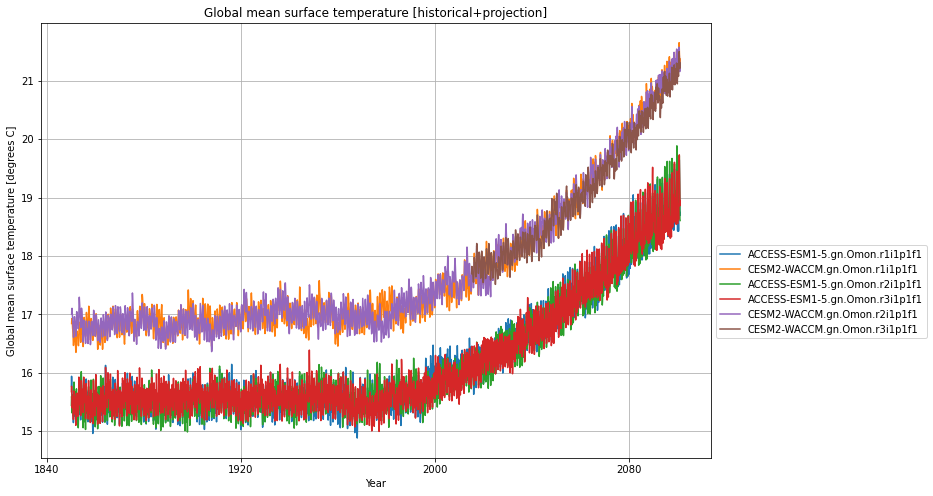

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
ax.grid()

for model_run in ddict_combined.keys():
    with ProgressBar():
        ds = ddict_combined[model_run]
        temp = ds['tos']
        temp.mean(dim=['x', 'y']).plot(ax=ax, label=model_run)

ax.legend(bbox_to_anchor=(1,0.5))
ax.set(
    xlabel='Year', 
    ylabel='Global mean surface temperature [degrees C]', 
    title='Global mean surface temperature [historical + SSP5-8.5 projection]'
)

---
_Other work here below_

In [ ]:
fig, ax = plt.subplots()
ds = ddict_combined['CESM2-WACCM.gn.Omon.r3i1p1f1']
temp = ds['tos']
temp.mean(dim=['x', 'y']).plot(ax=ax)